## 1. INTRODUÇÃO & OBJETIVOS

O presente trabalho insere-se no âmbito da unidade curricular **Aprendizagem Automática (APRAU)** do **Mestrado em Engenharia Informática do ISEP**, e tem como principal propósito aplicar, de forma prática, diferentes métodos de *Machine Learning* a um conjunto de dados reais, promovendo a compreensão dos seus fundamentos teóricos e das implicações na análise de resultados.

O dataset disponibilizado contém **metadados e análises áudio de um vasto conjunto de faixas musicais** de diferentes géneros. Cada registo descreve uma música através de múltiplas características quantitativas e qualitativas (tais como duração, intensidade, movimento, energia, tonalidade e pureza acústica), bem como **duas variáveis-alvo**:

- `target_class` — uma variável **categórica**, utilizada para tarefas de **classificação**;
- `target_regression` — uma variável **contínua**, utilizada para tarefas de **regressão**.

Os dados atribuídos a cada grupo incluem **três classes musicais distintas**.


O principal objetivo deste trabalho é aplicar diferentes métodos de aprendizagem automática sobre um dataset real de análise de áudio e metadados musicais, explorando tanto técnicas de regressão como de classificação.

O conjunto de dados fornecido contém faixas musicais de diferentes géneros, cada uma descrita por diversas características (features) — como duração, intensidade, energia, movimento, popularidade e pureza acústica — que permitem estudar relações e padrões entre variáveis.
Cada registo possui duas variáveis alvo:

**'target_regression'** – uma variável numérica que representa o impacto ou sucesso da faixa (usada em tarefas de regressão);
**'target_class'** – uma variável categórica que identifica a classe da faixa (usada em tarefas de classificação).

De forma resumida, o trabalho tem como objetivos principais:
1. **Analisar e compreender o dataset, através de:**
- Estatísticas descritivas e análise univariada (distribuição das variáveis);
- Análise bivariada (relações entre as variáveis e os targets);
- Identificação de padrões, outliers e colinearidade entre variáveis.

2. **Aplicar métodos de regressão linear:**
- Regressão Linear Simples, avaliando diferentes variáveis independentes e selecionando a mais adequada;
- Regressão Linear Múltipla, combinando várias features e comparando o desempenho dos modelos;
- Avaliar os resultados com métricas como R², MAE e RMSE, discutindo as diferenças observadas.

3. **Aplicar métodos de classificação supervisionada:**
- Treinar modelos com Logistic Regression, LDA e QDA;
- Avaliar o desempenho com diferentes estratégias de validação (Holdout, Cross-Validation k=5/k=10, LOOCV e Bootstrap);
- Analisar o impacto das técnicas de reamostragem na variância dos resultados.

4. **Explorar técnicas de seleção de variáveis (Feature Selection)**, avaliando se o uso de um subconjunto reduzido de features pode melhorar o desempenho dos modelos de classificação.

5. **Comparar, interpretar e discutir os resultados obtidos**, identificando as variáveis mais relevantes e os modelos com melhor capacidade preditiva.
o chat mandou-me isto para os objetivos

## 2. Data Understanding

### 2.1 Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings("ignore")

# Splits / resampling
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    LeaveOneOut,
    cross_val_score,
    cross_validate
)

# Metrics
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    accuracy_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

# Models
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

# Feature selection
from sklearn.feature_selection import f_classif

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils import resample  # for bootstrap

# Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Reproducibility
rng = np.random.default_rng(42)
pd.set_option("display.max_columns", 200)

### 2.2 Leitura dos Dados e Estrutura básica dos dados

In [2]:
df = pd.read_csv("dataset.csv")

display(df.head())

df.info()
print("Shape:", df.shape, "| Duplicates:", df.duplicated().sum())

print("\nTotal missing values:", df.isna().sum().sum())

# Basic splits
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

print("Numeric columns:", len(num_cols))
print("Categorical columns:", cat_cols)

# Check class balance (important for classification task)
print("\nClass distribution:")
print(df['target_class'].value_counts())


,duration_1,duration_2,duration_3,duration_4,duration_5,loudness_level,popularity_level,tempo_class,time_signature,key_mode,artist_song_count,album_freq,movement_index,intensity_level,verbal_density,purity_score,positivity_index,activity_rate,loudness_intensity,happy_dance,acoustics_instrumental,artists_avg_popularity,tempo_vs_genre,energy_rank_pct,loud_energy_ratio,mood_pca,mood_cluster,acoustic_valence_mood_cluster,explicit,signal_strength,mode_indicator,focus_factor,ambient_level,key_sin,key_cos,duration_log,duration_log_z,time_signature_class_boolean,loudness_yeo,is_instrumental,is_dance_hit,temp_zscore,resonance_factor,timbre_index,echo_constant,distorted_movement,signal_power,target_class,target_regression
0,0.0,0.0,0.0,1.0,0.0,2.0,4.0,2.0,0.221824,-1.511882,3.055348,0.465097,-0.592367,-0.215943,-0.558508,-0.538032,0.019031,-1.821983,0.231595,-0.342805,-0.291004,1.174469,-2.050394,-1.035640,-0.009063,-0.526052,-0.107785,1.384717,0.0,0.417,0.0,0.022,0.0974,0.000000e+00,1.000000,1.402643,-0.418639,1.0,-0.462119,0.0,0.0,-1.821975,-0.875781,0.516169,1,-0.517458,0.417,class_93,2.634456
1,0.0,0.0,1.0,0.0,0.0,3.0,4.0,1.0,0.221824,1.330170,0.747117,-0.088815,0.260452,1.083433,-0.482845,-0.798166,-0.293396,0.063556,1.096193,-0.235202,-0.301833,2.232929,-0.079104,0.618424,-0.009369,0.171172,-0.775793,0.396063,0.0,0.807,1.0,0.0177,0.1010,-8.660254e-01,0.500000,1.610770,0.299746,1.0,1.547522,0.0,0.0,0.063556,0.434668,0.085216,1,0.352649,0.807,class_93,2.679289
2,0.0,0.0,0.0,1.0,0.0,0.0,4.0,1.0,0.221824,-1.483743,3.752626,-0.429684,0.790583,0.463670,-0.351381,-0.698623,1.353599,0.595310,-0.206955,1.466782,-0.306003,-0.124485,0.476833,0.562618,-0.009394,1.333943,1.562236,0.725614,0.0,0.797,1.0,0.000745,0.0546,0.000000e+00,1.000000,1.245523,-0.960967,1.0,0.359507,0.0,0.0,0.595308,-0.193942,0.135326,1,-0.788285,0.797,class_93,2.813789
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.221824,0.204605,-0.406998,-0.387075,1.228517,0.147723,0.004234,0.421307,1.210885,0.062022,0.464803,1.637574,-0.305989,1.480086,-0.080708,-0.903516,-0.009104,0.686433,-0.775793,-1.251692,0.0,0.460,1.0,0.000141,0.0610,1.224647e-16,-1.000000,1.756630,0.803206,1.0,-0.061056,0.0,0.0,0.062022,0.784308,0.265456,1,0.197067,0.460,class_93,1.648124
4,0.0,0.0,1.0,0.0,0.0,1.0,4.0,1.0,0.221824,1.583423,-0.238689,-0.472292,0.600427,0.262052,-0.380700,-0.501944,0.076888,-0.006161,-0.179153,0.208423,-0.306278,-1.136754,-0.151992,-0.056277,-0.009326,0.225546,1.228232,1.384717,0.0,0.673,0.0,5.29e-05,0.3040,-5.000000e-01,0.866025,1.601809,0.268814,1.0,0.081898,0.0,0.0,-0.006161,-1.300966,0.629706,1,0.174018,0.673,class_93,2.320623


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   duration_1                     3000 non-null   float64
 1   duration_2                     3000 non-null   float64
 2   duration_3                     3000 non-null   float64
 3   duration_4                     3000 non-null   float64
 4   duration_5                     3000 non-null   float64
 5   loudness_level                 3000 non-null   float64
 6   popularity_level               3000 non-null   float64
 7   tempo_class                    3000 non-null   float64
 8   time_signature                 3000 non-null   float64
 9   key_mode                       3000 non-null   float64
 10  artist_song_count              3000 non-null   float64
 11  album_freq                     3000 non-null   float64
 12  movement_index                 3000 non-null   f

Notas:

O dataset contém **3000 registos** e **49 variáveis**, das quais **47 são numéricas** e **2 categóricas** (`focus_factor` e `target_class`).  
Não existem **valores nulos nem duplicados**, o que indica boa qualidade dos dados.

As classes (`target_class`) estão **equilibradas** — cada uma com 1000 amostras —, o que facilita a tarefa de classificação e evita enviesamentos.  
A variável `target_regression` será usada para regressão e `target_class` para classificação.



## 3. Data Cleaning

Tendo em conta que já temos dados de uma forma geral bastante limpos(sem duplicados ou nulos) para completar esta limpeza iremos aplicar a técnica de winsorization para lidar com possíveis outliers que tenhamos nos nossos dados

In [3]:
# Start a modeling copy (will be used later for regression/classification)
df_model = df.copy()

# Outlier winsorization per class, per numeric feature (except targets)
num_features = [
    c for c in df_model.select_dtypes(include=[np.number]).columns
    if c not in ['target_regression']
]

for feature in num_features:
    for cls in df_model['target_class'].unique():
        subset = df_model[df_model['target_class'] == cls][feature]

        Q1 = subset.quantile(0.25)
        Q3 = subset.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        mask = df_model['target_class'] == cls
        df_model.loc[mask, feature] = np.clip(
            df_model.loc[mask, feature],
            lower,
            upper
        )

print("df_model shape after winsorization:", df_model.shape)


df_model shape after winsorization: (3000, 49)


## 4. Univariate Analysis

### 4.1 Target Classes

Target Variables Distribution


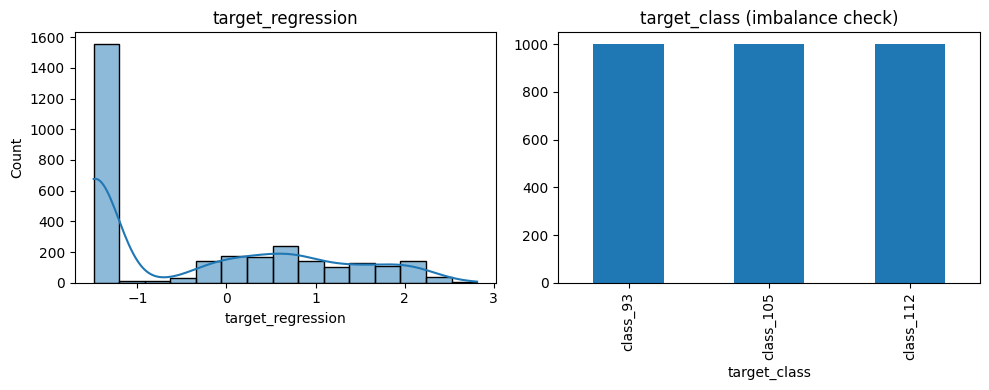

In [4]:
print("Target Variables Distribution")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(df['target_regression'].dropna(), kde=True, ax=axes[0])
axes[0].set_title("target_regression")

df['target_class'].value_counts().plot.bar(ax=axes[1])
axes[1].set_title("target_class (imbalance check)")

plt.tight_layout()
plt.show()


Nota:
* A variável target_regression apresenta forte assimetria negativa, com uma grande concentração de valores em torno de -1, e uma cauda longa positiva — o que poderá requerer normalização ou transformação (ex.: log ou Box-Cox) antes da modelação.
* A variável target_class está equilibrada entre as três classes (class_93, class_105, class_112), o que significa que não há problema de desbalanceamento de classes no problema de classificação.

### 4.2 Other Variables

Numeric summary:


,count,mean,std,min,25%,50%,75%,max
duration_1,3000.0,0.098667,0.298264,0.0,0.0,0.0,0.0,1.0
duration_2,3000.0,0.180000,0.384252,0.0,0.0,0.0,0.0,1.0
duration_3,3000.0,0.298667,0.457750,0.0,0.0,0.0,1.0,1.0
duration_4,3000.0,0.376000,0.484461,0.0,0.0,0.0,1.0,1.0
duration_5,3000.0,0.046667,0.210959,0.0,0.0,0.0,0.0,1.0


Categorical summary:


,count,unique,top,freq
focus_factor,3000,1221,0.0,982
target_class,3000,3,class_93,1000


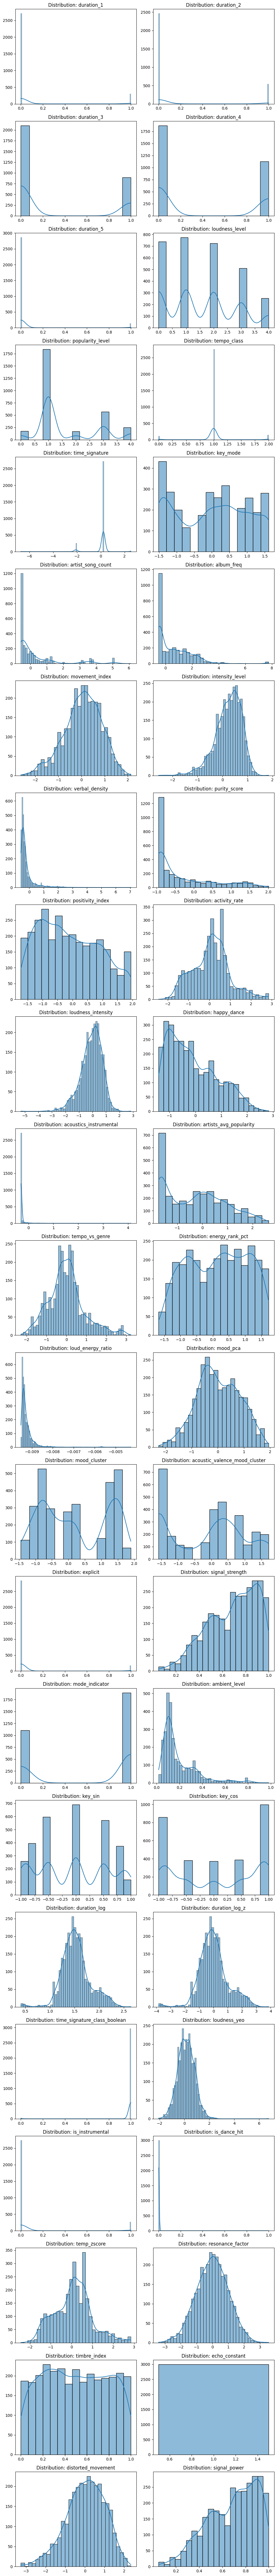

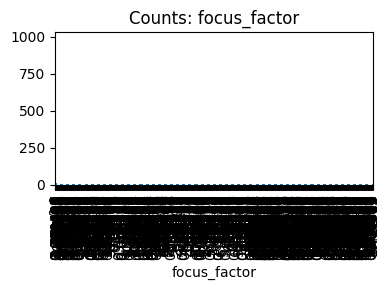

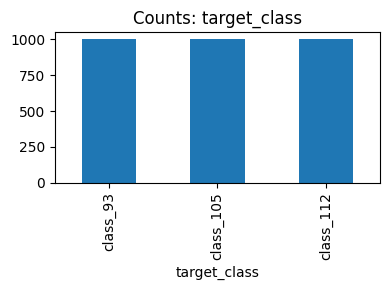

In [5]:
# Descriptive statistics (raw df)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

desc_num = df[num_cols].describe().T
desc_cat = df[cat_cols].describe().T

print("Numeric summary:")
display(desc_num.head())

print("Categorical summary:")
display(desc_cat)

# === Numeric distributions ===
num_features = [c for c in num_cols if c != 'target_regression']

n_cols = 2
n_rows = math.ceil(len(num_features) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_features):
    sns.histplot(df[col].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution: {col}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Remove empty subplots if any
for j in range(len(num_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# === Categorical distributions ===
for col in cat_cols:
    plt.figure(figsize=(4,3))
    df[col].value_counts(dropna=False).plot.bar()
    plt.title(f"Counts: {col}")
    plt.tight_layout()
    plt.show()


Notas:

* Dentro das variáveis numéricas observa-se a presença de distribuições assimétricas, tanto à esquerda — como é o caso de loudness_yeo e happy_dance —, quanto à direita, em variáveis como signal_power e signal_strength.
* Nota-se também que a variável echo_constant apresenta um único valor em todo o conjunto de dados, pelo que deverá ser descartada ou ignorada na modelação, uma vez que não acrescenta informação discriminativa.
* Adicionalmente, algumas variáveis binárias, como as duration_*, exibem apenas valores 0 e 1, confirmando o seu caráter indicador (dummy) e não contínuo.
* Relativamente ao histograma de focus_factor aparece completamente achatado e denso porque:
  1. Existem muitos valores únicos (ou quase únicos) mais de 1/3 são valores unicos;
  2. Nenhum valor tem uma contagem relevante, portanto não há barras visivelmente altas;

## 5. BIVARIATE ANALYSIS

Através da matriz de correlação é possível quantificar a força e direção das relações lineares entre todas as variáveis numéricas do dataset.
O heatmap gerado permite visualizar estas relações de forma intuitiva, destacando as correlações positivas (vermelho) e negativas (azul).


A tabela e o gráfico de barras seguintes listam as 10 variáveis com maior correlação (em valor absoluto) com a variável-alvo.


,Correlação com target_regression
target_regression,1.000000
artists_avg_popularity,0.804786
popularity_level,0.640606
duration_log,0.153175
duration_log_z,0.153175
energy_rank_pct,0.143358
signal_power,0.136441
signal_strength,0.136441
explicit,0.109541
is_instrumental,0.102334


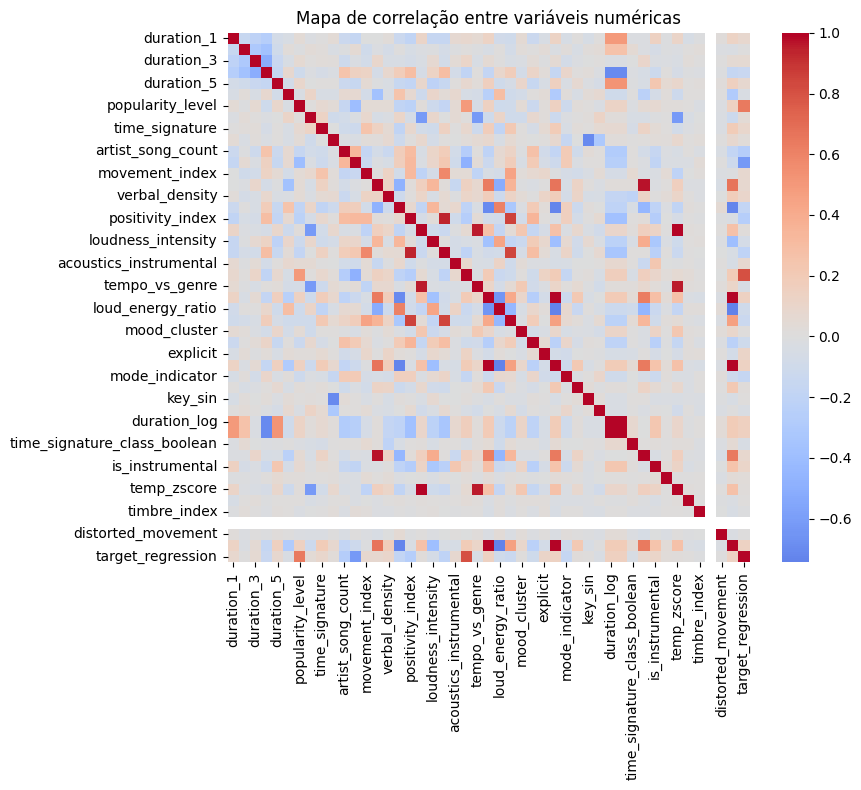

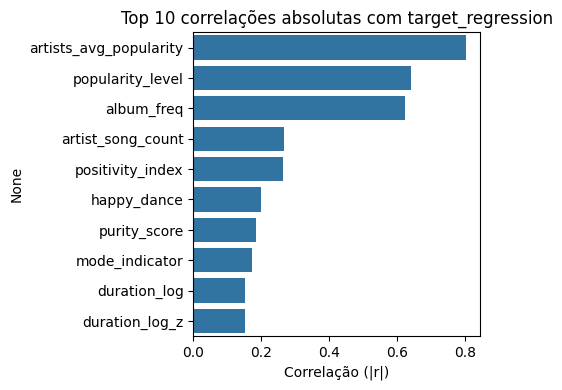

In [6]:
# Compute correlation of all numeric variables with the regression target
corr_matrix = df[num_cols].corr(numeric_only=True)
corr_with_target = corr_matrix['target_regression'].sort_values(ascending=False)

# Display correlation values
display(corr_with_target.to_frame("Correlação com target_regression"))

# Plot heatmap (for overall context)
plt.figure(figsize=(9, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Mapa de correlação entre variáveis numéricas")
plt.tight_layout()
plt.show()

# Correct: sort by absolute value to include strong negative correlations
top_corr = corr_with_target.drop('target_regression').abs().sort_values(ascending=False).head(10)

plt.figure(figsize=(5, 4))
sns.barplot(x=top_corr.values, y=top_corr.index)
plt.title("Top 10 correlações absolutas com target_regression")
plt.xlabel("Correlação (|r|)")
plt.tight_layout()
plt.show()


As três variáveis com maior correlação absoluta com target_regression — artists_avg_popularity (r = 0.84), popularity_level (r = 0.64) e album_freq (r = –0.62), destacam-se de forma clara em relação às restantes.

Este contraste revela que a popularidade do artista e da faixa musical constitui o fator com maior peso na explicação da variável de regressão, o que é coerente com a natureza do domínio musical, em que o sucesso e o alcance das faixas estão fortemente associados à notoriedade do intérprete.

Já a correlação negativa de album_freq sugere um comportamento inverso: quanto maior a frequência de álbuns lançados, menor tende a ser o valor de target_regression, possivelmente refletindo um efeito de saturação da produção artística

| Variável                                             | Correlação       | Interpretação                                                                                                                        |
| ---------------------------------------------------- | ---------------- | ------------------------------------------------------------------------------------------------------------------------------------ |
| `artists_avg_popularity`                             | **+0.84**        | Correlação positiva muito forte — músicas de artistas mais populares tendem a ter valores mais elevados de `target_regression`.      |
| `popularity_level`                                   | **+0.64**        | Reforça a forte influência da popularidade da faixa musical na variável de saída.                                                    |
| `album_freq`                                         | **–0.62**        | Correlação negativa elevada — músicas associadas a álbuns com muitas faixas tendem a ter valores mais baixos de `target_regression`. |

In [7]:
# Encode class labels numerically for ANOVA
cls_map = {label: i for i, label in enumerate(sorted(df['target_class'].unique()))}
y_class = df['target_class'].map(cls_map)

# Numeric predictors only (exclude regression target)
X_num = df.select_dtypes(include=[np.number]).drop(
    columns=['target_regression'],
    errors='ignore'
)

# ANOVA F-scores per feature for class discrimination
f_vals, p_vals = f_classif(X_num, y_class)

anova_df = pd.DataFrame({
    'Feature': X_num.columns,
    'F_value': f_vals,
    'p_value': p_vals
}).sort_values('F_value', ascending=False)

display(anova_df.head(10))

,Feature,F_value,p_value
23,energy_rank_pct,907.456210,7.277622e-309
45,signal_power,831.128531,6.959070e-288
29,signal_strength,831.128531,6.959070e-288
15,purity_score,690.694594,2.020746e-247
16,positivity_index,407.010163,4.214526e-157
11,album_freq,391.311379,1.019938e-151
38,is_instrumental,310.592061,2.611109e-123
24,loud_energy_ratio,268.380145,6.050774e-108
27,acoustic_valence_mood_cluster,265.502511,6.959630e-107
19,happy_dance,256.422277,1.589250e-103


'F_value': mede o grau de separação entre classes — quanto maior o F, mais a variável distingue bem as classes.

'p_value': indica a significância estatística dessa diferença — valores baixos (ex.: < 0.05) sugerem que a variável tem diferenças reais entre classes.

Para determinar/identificar as variaáveis mais relevantes ordenamos com uma tabela destacando as top 10 features.

Em termos de modelação, essas features são boas candidatas para algoritmos de classificação supervisionada (como LDA, QDA, Logistic Regression, etc.).

Seguidamente iremos criar uma boxplot para cada feature para comparar a distribuição dos valores das variáveis entre as diferentes classes.

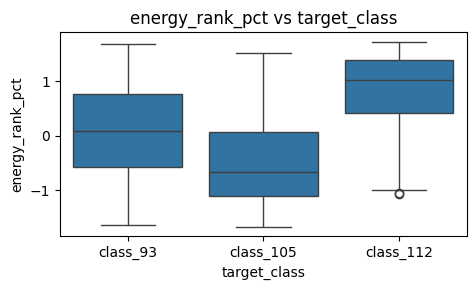

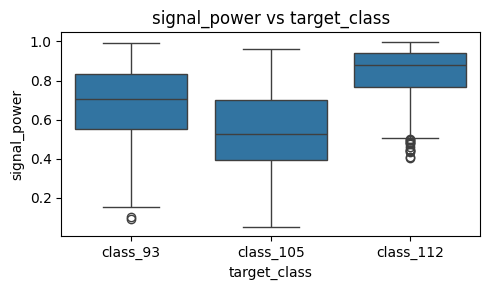

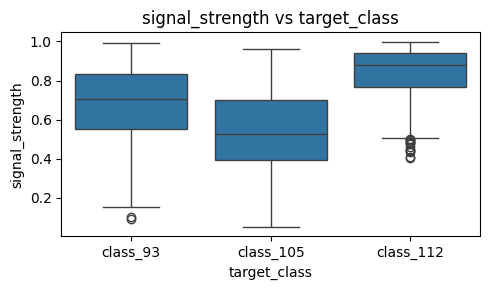

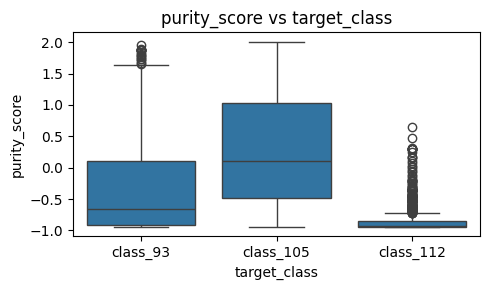

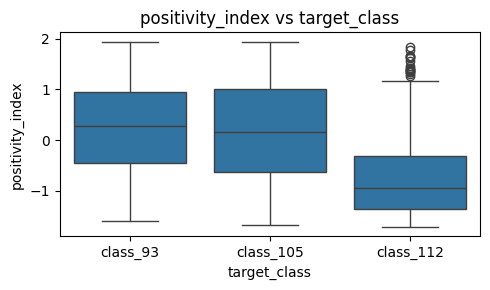

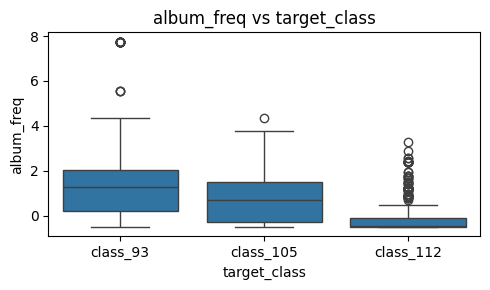

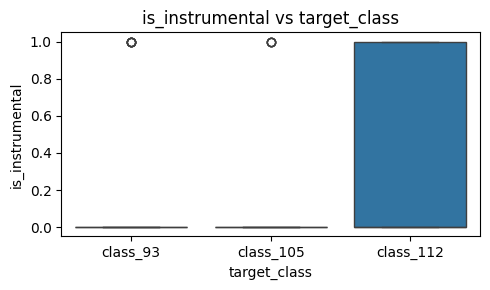

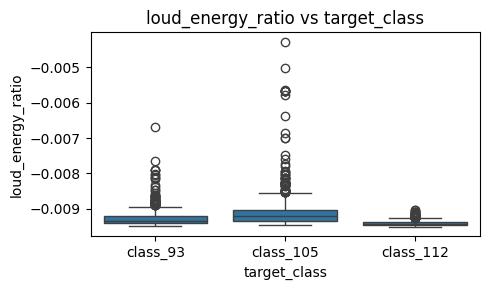

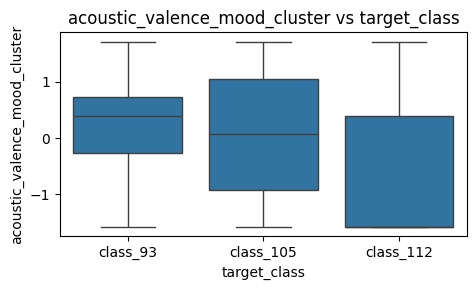

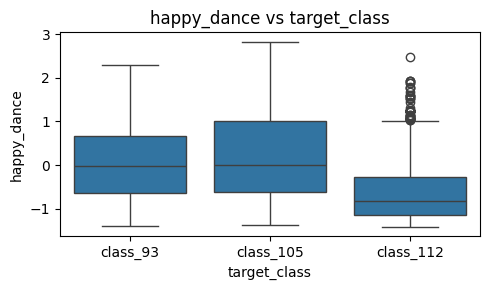

In [8]:
top_features = anova_df['Feature'].head(10).tolist()

for feature in top_features:
    plt.figure(figsize=(5, 3))
    sns.boxplot(x='target_class', y=feature, data=df)
    plt.title(f"{feature} vs target_class")
    plt.tight_layout()
    plt.show()


Após a análise de variância (ANOVA) e a visualização das distribuições através dos boxplots, procede-se à avaliação quantitativa dos outliers presentes nas variáveis mais discriminantes entre classes.

Nesta etapa, calcula-se, para cada variável e classe, o intervalo interquartil (IQR) e respetivos limites inferior e superior, determinando a percentagem de observações consideradas outliers.

O resultado é apresentado sob a forma de tabela resumo, permitindo identificar de forma rápida quais as variáveis e classes mais propensas à ocorrência de valores atípicos, informação útil para a compreensão da dispersão e robustez dos dados.


In [9]:
outlier_info_target = []

for feature in top_features:
    for cls in df['target_class'].unique():
        # Subconjunto da classe atual
        subset = df[df['target_class'] == cls][feature]

        # Quartis e IQR
        Q1 = subset.quantile(0.25)
        Q3 = subset.quantile(0.75)
        IQR = Q3 - Q1

        # Limites inferior e superior
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Contar outliers
        outliers = subset[(subset < lower_bound) | (subset > upper_bound)]
        perc_outliers = len(outliers) / len(subset) * 100

        outlier_info_target.append({
            "Feature": feature,
            "Classe": cls,
            "Nº Outliers": len(outliers),
            "Percentagem (%)": round(perc_outliers, 2)
        })

# Criar DataFrame
outlier_by_class_df = pd.DataFrame(outlier_info_target)

# Pivotar para visualização (features nas linhas, classes nas colunas)
outlier_summary = outlier_by_class_df.pivot(index="Feature", columns="Classe", values="Percentagem (%)")

# Mostrar tabela com gradiente azul
display(outlier_summary.style.background_gradient(cmap="Blues").format("{:.2f} %"))


Classe,class_105,class_112,class_93
Feature,,,
acoustic_valence_mood_cluster,0.00 %,0.00 %,0.00 %
album_freq,0.10 %,12.90 %,2.50 %
energy_rank_pct,0.00 %,0.20 %,0.00 %
happy_dance,0.00 %,5.40 %,0.00 %
is_instrumental,0.40 %,0.00 %,0.60 %
loud_energy_ratio,6.10 %,4.10 %,6.70 %
positivity_index,0.00 %,1.70 %,0.00 %
purity_score,0.00 %,13.70 %,1.80 %
signal_power,0.00 %,1.40 %,0.20 %


Nesta etapa realiza-se uma análise exploratória multivariada através de um pairplot, que representa graficamente as relações bivariadas entre as variáveis mais relevantes identificadas pela ANOVA.
Cada ponto no gráfico corresponde a uma observação do conjunto de dados, sendo as cores atribuídas conforme a classe (target_class).

Esta visualização permite observar tendências de separação entre classes, bem como padrões de correlação e agrupamento entre variáveis, facilitando a identificação de possíveis relações não lineares e zonas de sobreposição no espaço das características.

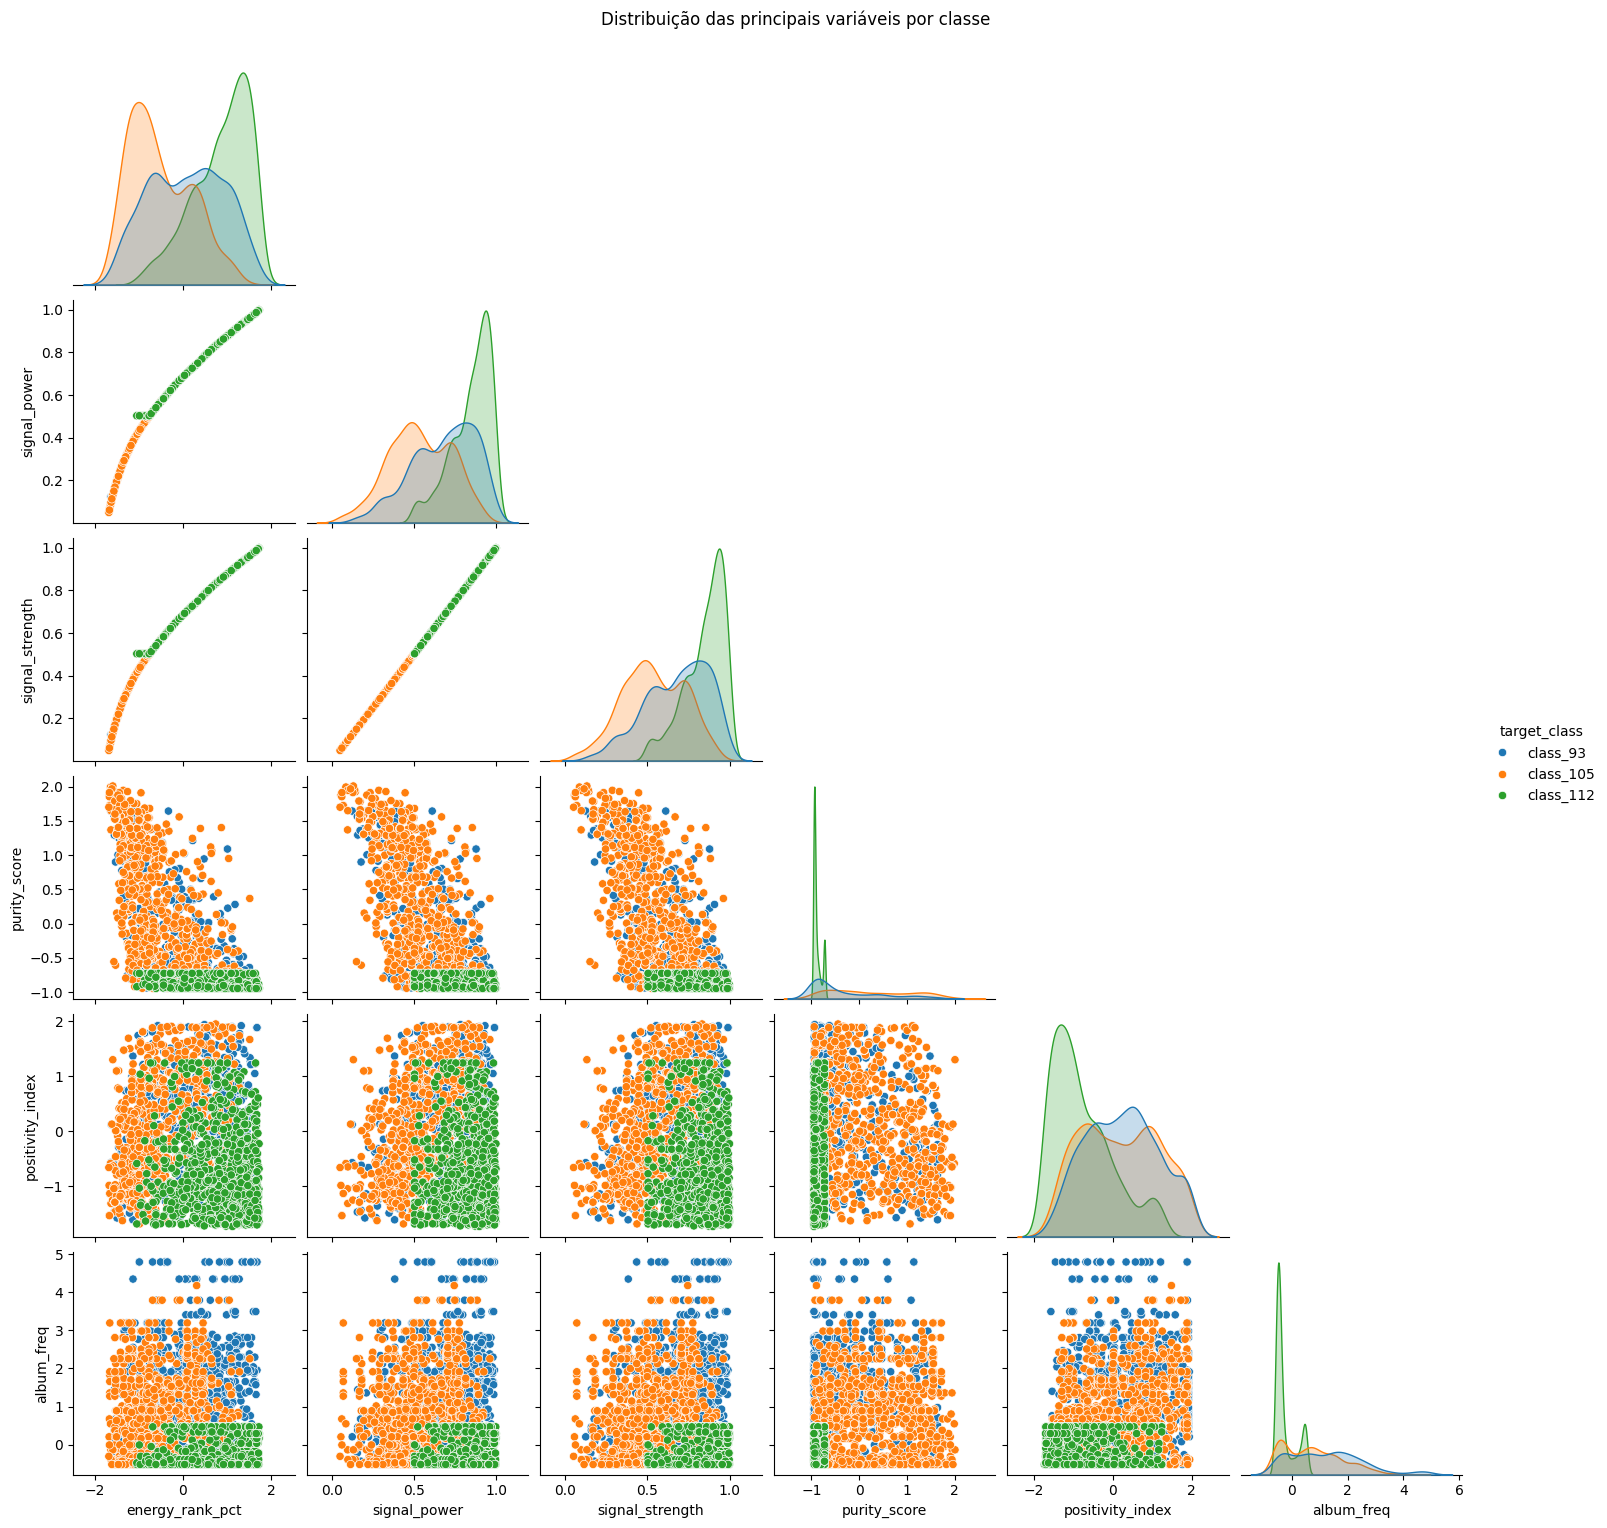

In [10]:
sns.pairplot(
    df_model,
    vars=top_features[:6],
    hue='target_class',
    corner=True
)
plt.suptitle("Distribuição das principais variáveis por classe", y=1.02)
plt.show()


O pairplot permite observar simultaneamente as relações bivariadas entre as principais variáveis identificadas pela ANOVA e a distribuição individual de cada uma por classe.

Nota-se que as variáveis signal_power e signal_strength exibem uma forte correlação positiva, visível na formação de uma linha quase linear entre ambas — um comportamento coerente, dado que ambas refletem medidas complementares da intensidade do sinal.

As distribuições de energy_rank_pct e positivity_index apresentam diferenças claras entre classes, sugerindo que estas características contribuem de forma significativa para a separação entre grupos.

Por outro lado, purity_score e album_freq mostram maior sobreposição entre classes, indicando uma capacidade discriminante mais limitada ou a presença de relações não lineares.
De forma geral, o gráfico confirma que as classes possuem padrões distintos em algumas dimensões acústicas e estruturais, sendo que as variáveis associadas à energia e intensidade são as que mais evidenciam tendências de separação visível no espaço das características.

## 6. Multicollinearity Analysis

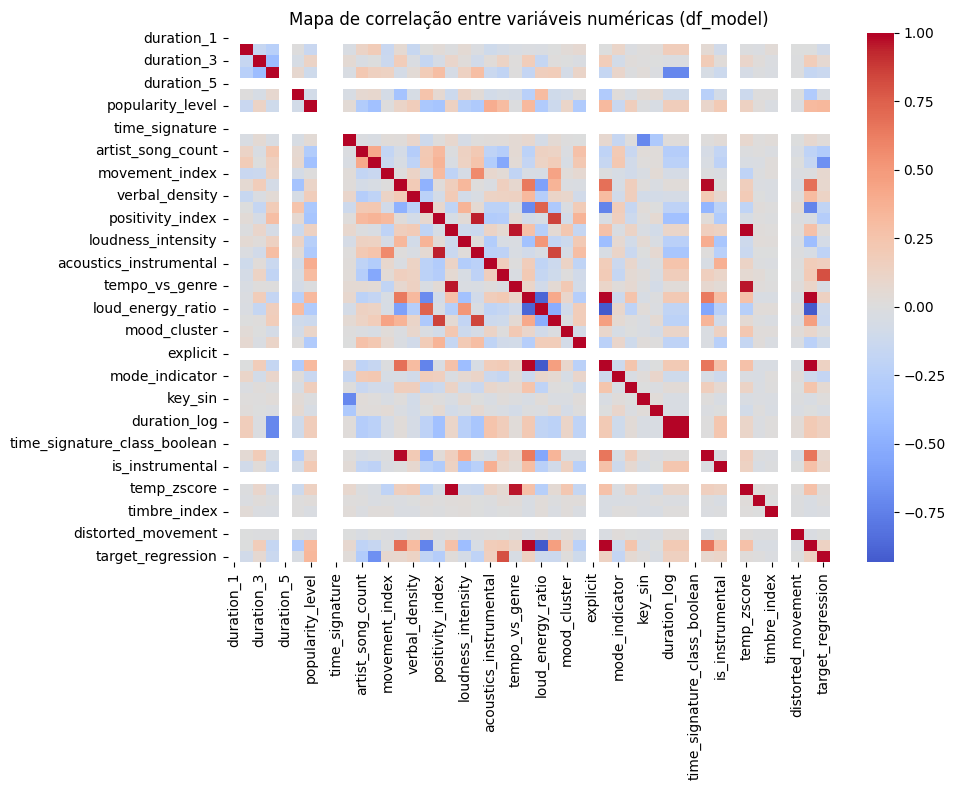

In [11]:
num_cols_model = df_model.select_dtypes(include=[np.number]).columns.tolist()
corr = df_model[num_cols_model].corr(numeric_only=True)

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Mapa de correlação entre variáveis numéricas (df_model)")
plt.tight_layout()
plt.show()


In [12]:
high_corr_pairs = (
    corr.abs()
    .unstack()
    .reset_index()
    .rename(columns={'level_0':'Feature_1','level_1':'Feature_2',0:'Correlation'})
    .query("Feature_1 != Feature_2 and Correlation > 0.8")
    .sort_values(by='Correlation', ascending=False)
)
high_corr_pairs = high_corr_pairs[
    high_corr_pairs.apply(lambda x: x['Feature_1'] < x['Feature_2'], axis=1)
].reset_index(drop=True)

display(high_corr_pairs)


,Feature_1,Feature_2,Correlation
0,duration_log,duration_log_z,1.000000
1,signal_power,signal_strength,1.000000
2,activity_rate,temp_zscore,1.000000
3,energy_rank_pct,signal_strength,0.986471
4,energy_rank_pct,signal_power,0.986471
5,intensity_level,loudness_yeo,0.984292
6,activity_rate,tempo_vs_genre,0.956239
7,temp_zscore,tempo_vs_genre,0.956239
8,happy_dance,positivity_index,0.940358
9,loud_energy_ratio,signal_power,0.933726


In [13]:
X_vif = (
    df_model
    .select_dtypes(include=[np.number])
    .drop(columns=['target_regression'], errors='ignore')
    .fillna(0)
)

X_vif_const = add_constant(X_vif)

vif_data = pd.DataFrame({
    "Feature": X_vif_const.columns,
    "VIF": [
        variance_inflation_factor(X_vif_const.values, i)
        for i in range(X_vif_const.shape[1])
    ]
})

# Remove constant and sort
vif_data = vif_data[vif_data["Feature"] != "const"].sort_values("VIF", ascending=False)
display(vif_data.head(20))


,Feature,VIF
45,signal_power,inf
40,temp_zscore,inf
35,duration_log_z,inf
34,duration_log,inf
29,signal_strength,inf
17,activity_rate,inf
25,mood_pca,3802.387023
16,positivity_index,2549.714490
23,energy_rank_pct,285.637569
12,movement_index,143.615083


Com base nos resultados obtidos na análise de multicolinearidade (VIF e correlação de Pearson), foi possível identificar um conjunto de variáveis altamente correlacionadas entre si ou redundantes.
Em particular, observou-se colinearidade perfeita ou quase perfeita entre variáveis derivadas do mesmo conceito, como:
 * duration_log e duration_log_z
 * signal_power e signal_strenght
 * activity_rate e tempz_score

Além disso, existem outras variaveis com forte correlações indicando redundância informacional significativa
 * Indicadores derivados (mood_pca, positivity_index, energy_rank_pct) têm VIF superiores a 200, apontando para forte multicolinearidade com outras variáveis.
 * Outras variáveis como movement_index, loudness_yeo, intensity_level e happy_dance também apresentam VIFs elevados (entre 30 e 150), mostrando correlação substancial mas não total.

Para mitigar os efeitos da multicolinearidade e reduzir a redundância entre preditores, foi decidido remover as variáveis com VIF infinito ou correlação superior a 0.9, mantendo apenas uma variável representativa por grupo.
Assim, as seguintes variáveis foram eliminadas do conjunto de treino:

In [14]:
to_drop = [
    # duration & derived variables (highly redundant between them)
    'duration_1','duration_2','duration_3','duration_4','duration_5','duration_log_z',
    # strong collinearity / standardised versions
    'temp_zscore','activity_rate','movement_index','positivity_index','mood_pca',
    # redundant energy/signal style metrics
    'signal_power','energy_rank_pct','loudness_yeo','happy_dance'
]

df_clean = df_model.drop(columns=[c for c in to_drop if c in df_model.columns]).copy()

print("Remaining columns:", df_clean.shape[1])
print("Dropped:", len([c for c in to_drop if c in df_model.columns]), "columns")


Remaining columns: 34
Dropped: 15 columns


In [15]:
# Get numeric columns safely
num_cols_clean = df_clean.select_dtypes(include=[np.number]).columns.tolist()

X_vif2 = (
    df_clean[num_cols_clean]
    .drop(columns=['target_regression'], errors='ignore')
    .fillna(0)
)

X_vif2_const = add_constant(X_vif2)

vif_df2 = pd.DataFrame({
    'Feature': X_vif2_const.columns,
    'VIF': [
        variance_inflation_factor(X_vif2_const.values, i)
        for i in range(X_vif2_const.shape[1])
    ]
})

# Remove the constant term and sort
vif_df2 = vif_df2[vif_df2['Feature'] != 'const'].sort_values('VIF', ascending=False)
display(vif_df2.head(15))


,Feature,VIF
7,intensity_level,16.163435
18,signal_strength,14.933525
14,loud_energy_ratio,14.086774
10,loudness_intensity,11.732768
4,key_mode,2.595319
9,purity_score,2.502155
21,key_sin,2.287514
6,album_freq,1.765356
0,loudness_level,1.573924
1,popularity_level,1.501698


Assim como é possivél ver pela tabela acabamos por ddiminuir fortemente o multicolinearidade entre variaveis sem perder dados que poderiam vir a ser essencias para os nossos modelos.

## 7. Regression Modeling

In [16]:
# Separate predictors (numerical only) and regression target
features_reg = [
    c for c in df_clean.columns
    if c not in ['target_regression', 'target_class', 'focus_factor']
]

X = df_clean[features_reg].select_dtypes(include=[np.number]).copy()
y = df_clean['target_regression'].astype(float).copy()

# Train/test split (Holdout)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Impute missing numeric values (if any)
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns
)
X_test = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns
)


In [17]:
results_simple = []
for col in X.columns:
    lr = LinearRegression()
    lr.fit(X_train[[col]], y_train)
    y_pred = lr.predict(X_test[[col]])
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))   
    results_simple.append((col, r2, mae, rmse))

simple_df = pd.DataFrame(results_simple, columns=['Feature','R2','MAE','RMSE'])
simple_df = simple_df.sort_values('R2', ascending=False)
display(simple_df.head(10))

best_feature = simple_df.iloc[0]['Feature']
print("Best feature for Simple LR:", best_feature)


,Feature,R2,MAE,RMSE
12,artists_avg_popularity,0.676296,0.457400,0.724060
6,album_freq,0.461701,0.759602,0.933710
1,popularity_level,0.084257,1.015469,1.217832
5,artist_song_count,0.075577,1.033129,1.223590
19,mode_indicator,0.051067,1.119669,1.239705
9,purity_score,0.036573,1.101622,1.249137
23,duration_log,0.021549,1.130940,1.258839
11,acoustics_instrumental,0.019194,1.132436,1.260353
18,signal_strength,0.015896,1.126565,1.262470
16,acoustic_valence_mood_cluster,0.009389,1.133894,1.266637


Best feature for Simple LR: artists_avg_popularity


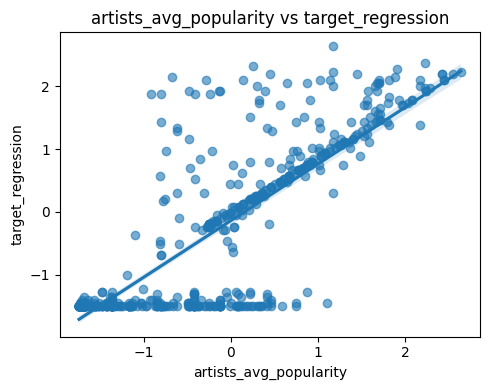

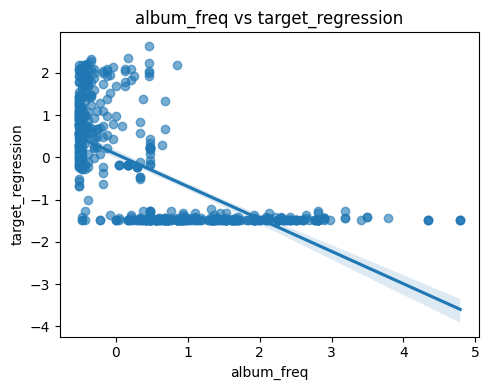

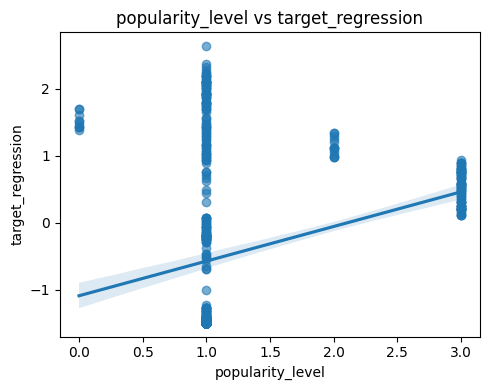

In [18]:
top3 = simple_df.head(3)['Feature'].tolist()

for feat in top3:
    plt.figure(figsize=(5,4))
    sns.regplot(x=X_test[feat], y=y_test, scatter_kws={'alpha':0.6})
    plt.title(f"{feat} vs target_regression")
    plt.xlabel(feat)
    plt.ylabel("target_regression")
    plt.tight_layout()
    plt.show()


A regressão linear simples foi aplicada individualmente a cada variável numérica para avaliar a sua relação com a variável alvo `target_regression`.  
Os resultados mostram que apenas algumas variáveis apresentam poder explicativo significativo.

A variável **`artists_avg_popularity`** destacou-se como o **melhor preditor individual**, com  
**R² = 0.676**, **MAE = 0.457** e **RMSE = 0.724**, demonstrando uma **forte relação linear positiva** com o alvo — quanto maior a popularidade média do artista, maior tende a ser o valor previsto.  
Esta tendência é confirmada visualmente pelo gráfico, onde os pontos se alinham fortemente em torno da linha de regressão.

A variável **`album_freq`** surge em segundo lugar (**R² = 0.461**), apresentando uma **relação linear negativa**, indicando que um número mais elevado de álbuns tende a estar associado a valores mais baixos da variável dependente.  
Apesar da maior dispersão dos pontos, a tendência descendente é claramente visível.

Por outro lado, variáveis como **`popularity_level`**, **`artist_song_count`** ou **`purity_score`** revelam um poder explicativo muito reduzido (**R² < 0.1**), sem padrão linear consistente entre o preditor e o alvo.

Em suma, a análise confirma que **a popularidade média do artista é o fator mais relevante** na previsão da variável alvo, enquanto as restantes variáveis isoladas apresentam impacto limitado.  
Nas próximas etapas, será testada uma **regressão múltipla** para verificar se a combinação de várias variáveis melhora o desempenho global do modelo.

## 8. Multiple Linear Regression

In [19]:
# Correlation with regression target
corr_with_y = df_clean.corr(numeric_only=True)['target_regression'].sort_values(ascending=False)
corr_with_y

target_regression                1.000000
artists_avg_popularity           0.804888
popularity_level                 0.328509
acoustics_instrumental           0.158513
duration_log                     0.152945
signal_strength                  0.137288
verbal_density                   0.130489
is_instrumental                  0.106829
intensity_level                  0.083210
ambient_level                    0.056750
key_mode                         0.030032
key_sin                          0.014923
mood_cluster                     0.012707
resonance_factor                 0.007864
distorted_movement               0.002554
timbre_index                    -0.014423
key_cos                         -0.033870
loudness_level                  -0.034294
tempo_vs_genre                  -0.046623
loudness_intensity              -0.067132
acoustic_valence_mood_cluster   -0.109147
loud_energy_ratio               -0.115268
mode_indicator                  -0.171697
purity_score                    -0

Correlação com a variável alvo (target_regression)

* A análise de correlação mostra que artists_avg_popularity é a variável mais relacionada com o alvo (correlação ≈ 0.80), o que confirma o que já tinha sido observado na regressão simples.
* A variável album_freq apresenta uma forte correlação negativa (≈ -0.67), ou seja, quanto maior o número de álbuns, menor tende a ser o valor do alvo.
* Outras variáveis como popularity_level, acoustics_instrumental e duration_log têm correlações mais baixas (0.1–0.3), indicando contributo moderado.

In [20]:
# Get top correlated features (excluding the target)
top3 = corr_with_y.drop('target_regression', errors='ignore').abs().head(3).index.tolist()
top5 = corr_with_y.drop('target_regression', errors='ignore').abs().head(5).index.tolist()
top4 = corr_with_y.drop('target_regression', errors='ignore').abs().head(4).index.tolist()
top10 = corr_with_y.drop('target_regression', errors='ignore').abs().head(10).index.tolist()
top5_no4 = [top10[i] for i in [0, 1, 2, 4]]

print("Top 5 features:", top5)
print("Top 10 features:", top10)

Top 5 features: ['artists_avg_popularity', 'popularity_level', 'acoustics_instrumental', 'duration_log', 'signal_strength']
Top 10 features: ['artists_avg_popularity', 'popularity_level', 'acoustics_instrumental', 'duration_log', 'signal_strength', 'verbal_density', 'is_instrumental', 'intensity_level', 'ambient_level', 'key_mode']


In [21]:
def eval_lr(cols, name):
    lr = LinearRegression()
    lr.fit(X_train[cols], y_train)
    y_pred = lr.predict(X_test[cols])
    return {
        'Model': name,
        'R2': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'Features': cols
    
    }

In [22]:
models_reg = [
    eval_lr([best_feature], "best feature"),     # simple model (baseline)
    eval_lr(top3, "top 3"),
    eval_lr(top4, "top 4"),
    eval_lr(top5_no4, "top 5 without 4th feature"),
    eval_lr(top5, "top 5"),
    eval_lr(top10, "top 10"),
    eval_lr(X.columns.tolist(), "all")  # all numeric features
]

reg_results = pd.DataFrame(models_reg).sort_values('R2', ascending=False)
display(reg_results[['Model','R2','MAE','RMSE']])

,Model,R2,MAE,RMSE
6,all,0.753703,0.440693,0.631583
5,top 10,0.687626,0.456594,0.711276
4,top 5,0.686168,0.464437,0.712934
3,top 5 without 4th feature,0.685897,0.464204,0.713242
2,top 4,0.682515,0.465687,0.717071
1,top 3,0.682461,0.465476,0.717132
0,best feature,0.676296,0.457400,0.724060


Foram comparadas as seguintes configurações:
- **Best Feature:** apenas a variável mais correlacionada (`artists_avg_popularity`) — modelo de referência;  
- **Top 3, Top 4, Top 5, Top 5 without 4 feature, Top 10:** conjuntos crescentes de variáveis mais correlacionadas com o alvo;  
- **All:** todas as variáveis numéricas do dataset.

Os resultados mostram uma **melhoria global do R²** à medida que se adicionam mais variáveis, passando de **0.676 (modelo simples)** para **0.754 (modelo completo)**.  
Contudo, observa-se que o **modelo “Top 5”** apresenta um desempenho muito semelhante ao “Top 10” e ao “All”, com **R² ≈ 0.686** e erros ligeiramente superiores, mas com **menos variáveis** — o que o torna **mais eficiente e interpretável**, sem perda significativa de desempenho.

Este resultado sugere que **nem sempre adicionar mais preditores se traduz em melhorias substanciais**; o modelo “Top 5” representa um bom equilíbrio entre **precisão e simplicidade**, sendo potencialmente mais estável e menos sujeito a sobreajuste (*overfitting*).

O modelo completo (“All”) atinge o melhor valor absoluto (**R² = 0.7537**, **MAE = 0.4407**, **RMSE = 0.6316**), explicando cerca de **75% da variabilidade da variável dependente**.  
Ainda assim, considerando a relação custo-benefício, o “Top 5” pode ser preferível em cenários onde a interpretabilidade e a eficiência são mais relevantes do que o ganho marginal de precisão.

Em síntese, a regressão múltipla provou ser superior à regressão simples, mas a análise comparativa demonstra a importância de avaliar o **equilíbrio entre complexidade e desempenho** na escolha do modelo final.

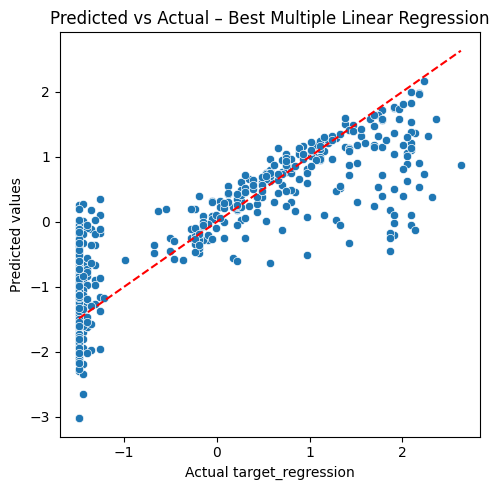

In [23]:
# Use the best-performing model (highest R²)
best_model_features = reg_results.iloc[0]['Features']
lr_best = LinearRegression().fit(X_train[best_model_features], y_train)
y_pred_best = lr_best.predict(X_test[best_model_features])

plt.figure(figsize=(5,5))
sns.scatterplot(x=y_test, y=y_pred_best)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Predicted vs Actual – Best Multiple Linear Regression")
plt.xlabel("Actual target_regression")
plt.ylabel("Predicted values")
plt.tight_layout()
plt.show()
 

Observa-se que a maioria dos pontos se distribui **muito próxima da linha de tendência**, o que indica um **ajuste linear consistente** e confirma o bom desempenho do modelo múltiplo.  
A relação é claramente positiva, demonstrando que o modelo consegue **capturar corretamente a direção e magnitude das variações** da variável dependente.

Apesar disso, verifica-se alguma **dispersão nas extremidades (outliers)**, sugerindo que o modelo tem **ligeiras dificuldades em prever valores muito altos ou muito baixos** do `target_regression`.  
Esta observação é coerente com a diferença entre **MAE (0.44)** e **RMSE (0.63)**, que indica a presença de **alguns erros maiores**, embora sem comprometer a estabilidade global.

No geral, a densidade de pontos junto à diagonal reforça a **robustez e capacidade explicativa** do modelo, validando os bons resultados obtidos em termos de **R² = 0.75**, **MAE = 0.44** e **RMSE = 0.63**.  
O modelo mostra-se, assim, **bem ajustado e fiável**, conseguindo representar de forma adequada as relações lineares entre as variáveis explicativas e a variável alvo.



## 9. Classification Modeling

### Preparação dos Dados para o Modelo de Classificação

Antes de treinar o modelo, é necessário garantir que os dados estão limpos e prontos para uso.

Passos principais:

1. **Verificar colunas-alvo**  
2. **Converter tipos de dados**  
3. **Separar variáveis**  
4. **Tratar dados numéricos** 
5. **Dividir em treino e teste**  


In [24]:
# Ensure target columns exist
if 'target_class' not in df_clean.columns:
    df_clean['target_class'] = df_model['target_class']
if 'target_regression' not in df_clean.columns:
    df_clean['target_regression'] = df_model['target_regression']

# Coerce focus_factor (object) to numeric
df_clean['focus_factor'] = pd.to_numeric(df_clean['focus_factor'], errors='coerce')

# === Classification dataset ===
y_cls = df_clean['target_class']
X_cls = df_clean.drop(columns=['target_class','target_regression'], errors='ignore')

# Ensure all predictors are numeric and fill missing with medians
X_cls = X_cls.select_dtypes(include=np.number).fillna(X_cls.median(numeric_only=True))

print("X_cls shape:", X_cls.shape)
print("y_cls distribution:\n", y_cls.value_counts())

# Split with stratification if all classes have >1 record
if y_cls.value_counts().min() > 1:
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
        X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
    )
else:
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
        X_cls, y_cls, test_size=0.2, random_state=42
    )


X_cls shape: (3000, 32)
y_cls distribution:
 target_class
class_93     1000
class_105    1000
class_112    1000
Name: count, dtype: int64


### Função de Avaliação dos Modelos de Classificação

Esta função (`evaluate_classifier`) é usada para avaliar o desempenho de modelos de classificação de forma completa e consistente.

Passos principais:

1. **Treino e avaliação inicial (Holdout)**  
   - O modelo é treinado com o conjunto de treino (`X_train`, `y_train`) e testado no conjunto de teste (`X_test`, `y_test`).  
   - Calcula as seguintes métricas:
     - **Accuracy** – taxa de acerto total  
     - **Recall (macro)** – média do recall entre classes  
     - **F1 (macro)** – equilíbrio entre precisão e recall  
     - **ROC AUC (ovr)** – qualidade geral das previsões (se o modelo permitir `predict_proba`)

2. **Validação cruzada (Cross Validation)**  
   - Executa duas versões:
     - **5-Fold**: o dataset é dividido em 5 partes.  
     - **10-Fold**: o dataset é dividido em 10 partes.  
   - Cada versão retorna a média das métricas **Accuracy**, **Recall (macro)** e **F1 (macro)**.

3. **Leave-One-Out Cross Validation (LOOCV)**  
   - Testa o modelo várias vezes, deixando sempre **uma única amostra para teste** e usando o resto para treino.  
   - Mede as mesmas três métricas principais.

4. **Bootstrap Evaluation**  
   - Cria **100 amostras aleatórias com reposição** do conjunto de treino.  
   - Treina e avalia o modelo em cada amostra.  
   - Calcula a média das métricas obtidas.

5. **Resultado final**  
   - Mostra os resultados de cada avaliação em tabelas.  
   - Retorna um dicionário com todas as métricas calculadas, útil para armazenar e comparar modelos mais tarde.

In [25]:
def evaluate_classifier(model, X_train, X_test, y_train, y_test, rng):
    model_name = type(model).__name__
    print(f"\n============================")
    print(f"Model: {model_name}")
    print("============================\n")

    # --- Holdout Evaluation ---
    model_fit = model.__class__(**model.get_params())
    model_fit.fit(X_train, y_train)
    preds = model_fit.predict(X_test)
    probs = model_fit.predict_proba(X_test) if hasattr(model_fit, "predict_proba") else None

    holdout_metrics = {
        "Accuracy": accuracy_score(y_test, preds),
        "Recall (macro)": recall_score(y_test, preds, average="macro"),
        "F1 (macro)": f1_score(y_test, preds, average="macro"),
        "ROC AUC (ovr)": roc_auc_score(pd.get_dummies(y_test), probs, multi_class="ovr") if probs is not None else np.nan
    }

    df_holdout = pd.DataFrame(holdout_metrics, index=[model_name])
    print("Holdout Results:")
    display(df_holdout)

    # --- 5-Fold Cross Validation ---
    skf5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv5 = cross_validate(
        model, X_train, y_train,
        cv=skf5,
        scoring=["accuracy", "recall_macro", "f1_macro"],
        n_jobs=-1
    )

    df_cv5 = pd.DataFrame({
        "Accuracy": [cv5["test_accuracy"].mean()],
        "Recall (macro)": [cv5["test_recall_macro"].mean()],
        "F1 (macro)": [cv5["test_f1_macro"].mean()]
    }, index=[model_name])
    print("\n5-Fold Cross Validation:")
    display(df_cv5)

    # --- 10-Fold Cross Validation ---
    skf10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv10 = cross_validate(
        model, X_train, y_train,
        cv=skf10,
        scoring=["accuracy", "recall_macro", "f1_macro"],
        n_jobs=-1
    )

    df_cv10 = pd.DataFrame({
        "Accuracy": [cv10["test_accuracy"].mean()],
        "Recall (macro)": [cv10["test_recall_macro"].mean()],
        "F1 (macro)": [cv10["test_f1_macro"].mean()]
    }, index=[model_name])
    print("\n10-Fold Cross Validation:")
    display(df_cv10)

    # --- Leave-One-Out Cross Validation (LOOCV) ---
    loo = LeaveOneOut()
    cvloo = cross_validate(
        model, X_train, y_train,
        cv=loo,
        scoring=["accuracy", "recall_macro", "f1_macro"]
    )

    df_loocv = pd.DataFrame({
        "Accuracy": [cvloo["test_accuracy"].mean()],
        "Recall (macro)": [cvloo["test_recall_macro"].mean()],
        "F1 (macro)": [cvloo["test_f1_macro"].mean()]
    }, index=[model_name])
    print("\nLeave-One-Out Cross Validation (LOOCV):")
    display(df_loocv)

    # --- Bootstrap Evaluation ---
    boot_metrics = {"Accuracy": [], "Recall (macro)": [], "F1 (macro)": []}
    for _ in range(100):
        idx = rng.integers(0, len(y_train), len(y_train))
        X_b = X_train.iloc[idx]
        y_b = y_train.iloc[idx]

        m_boot = model.__class__(**model.get_params())
        m_boot.fit(X_b, y_b)
        preds_b = m_boot.predict(X_b)
        boot_metrics["Accuracy"].append(accuracy_score(y_b, preds_b))
        boot_metrics["Recall (macro)"].append(recall_score(y_b, preds_b, average="macro"))
        boot_metrics["F1 (macro)"].append(f1_score(y_b, preds_b, average="macro"))

    df_boot = pd.DataFrame({
        "Accuracy": [np.mean(boot_metrics["Accuracy"])],
        "Recall (macro)": [np.mean(boot_metrics["Recall (macro)"])],
        "F1 (macro)": [np.mean(boot_metrics["F1 (macro)"])]
    }, index=[model_name])
    print("\nBootstrap Results:")
    display(df_boot)

    # Return all metrics as dict (for storage or summary table)
    return {
        "Model": model_name,
        "Holdout_Accuracy": holdout_metrics["Accuracy"],
        "Holdout_Recall": holdout_metrics["Recall (macro)"],
        "Holdout_F1": holdout_metrics["F1 (macro)"],
        "Holdout_ROC_AUC": holdout_metrics["ROC AUC (ovr)"],
        "CV5_Accuracy": df_cv5["Accuracy"].iloc[0],
        "CV5_Recall": df_cv5["Recall (macro)"].iloc[0],
        "CV5_F1": df_cv5["F1 (macro)"].iloc[0],
        "CV10_Accuracy": df_cv10["Accuracy"].iloc[0],
        "CV10_Recall": df_cv10["Recall (macro)"].iloc[0],
        "CV10_F1": df_cv10["F1 (macro)"].iloc[0],
        "LOOCV_Accuracy": df_loocv["Accuracy"].iloc[0],
        "LOOCV_Recall": df_loocv["Recall (macro)"].iloc[0],
        "LOOCV_F1": df_loocv["F1 (macro)"].iloc[0],
        "Bootstrap_Accuracy": df_boot["Accuracy"].iloc[0],
        "Bootstrap_Recall": df_boot["Recall (macro)"].iloc[0],
        "Bootstrap_F1": df_boot["F1 (macro)"].iloc[0]
    }


In [26]:
models = [
    LogisticRegression(max_iter=500, random_state=42),
    LDA(),
    QDA()
]

results = [
    evaluate_classifier(m, X_train_c, X_test_c, y_train_c, y_test_c, rng)
    for m in models
]



Model: LogisticRegression

Holdout Results:


,Accuracy,Recall (macro),F1 (macro),ROC AUC (ovr)
LogisticRegression,0.785,0.785,0.783119,0.921825



5-Fold Cross Validation:


,Accuracy,Recall (macro),F1 (macro)
LogisticRegression,0.803333,0.803333,0.802408



10-Fold Cross Validation:


,Accuracy,Recall (macro),F1 (macro)
LogisticRegression,0.801667,0.801667,0.800627



Leave-One-Out Cross Validation (LOOCV):


,Accuracy,Recall (macro),F1 (macro)
LogisticRegression,0.8075,0.8075,0.8075



Bootstrap Results:


,Accuracy,Recall (macro),F1 (macro)
LogisticRegression,0.821242,0.821291,0.820816



Model: LinearDiscriminantAnalysis

Holdout Results:


,Accuracy,Recall (macro),F1 (macro),ROC AUC (ovr)
LinearDiscriminantAnalysis,0.77,0.77,0.774397,0.916267



5-Fold Cross Validation:


,Accuracy,Recall (macro),F1 (macro)
LinearDiscriminantAnalysis,0.792917,0.792917,0.796157



10-Fold Cross Validation:


,Accuracy,Recall (macro),F1 (macro)
LinearDiscriminantAnalysis,0.792917,0.792917,0.79582



Leave-One-Out Cross Validation (LOOCV):


,Accuracy,Recall (macro),F1 (macro)
LinearDiscriminantAnalysis,0.791667,0.791667,0.791667



Bootstrap Results:


,Accuracy,Recall (macro),F1 (macro)
LinearDiscriminantAnalysis,0.805821,0.805607,0.808574



Model: QuadraticDiscriminantAnalysis

Holdout Results:


,Accuracy,Recall (macro),F1 (macro),ROC AUC (ovr)
QuadraticDiscriminantAnalysis,0.681667,0.681667,0.674031,0.844333



5-Fold Cross Validation:


,Accuracy,Recall (macro),F1 (macro)
QuadraticDiscriminantAnalysis,0.71875,0.71875,0.708972



10-Fold Cross Validation:


,Accuracy,Recall (macro),F1 (macro)
QuadraticDiscriminantAnalysis,0.706667,0.706667,0.701326



Leave-One-Out Cross Validation (LOOCV):


,Accuracy,Recall (macro),F1 (macro)
QuadraticDiscriminantAnalysis,0.748333,0.748333,0.748333



Bootstrap Results:


,Accuracy,Recall (macro),F1 (macro)
QuadraticDiscriminantAnalysis,0.733858,0.734221,0.731674


As métricas analisadas foram:
- **Accuracy** – percentagem de previsões corretas.  
- **Recall (macro)** – média do recall entre classes.  
- **F1 (macro)** – equilíbrio entre precisão e recall.  
- **ROC AUC (ovr)** – desempenho geral do modelo (apenas para o holdout).
  
#### Logistic Regression
| Validação | Accuracy | Recall (macro) | F1 (macro) | ROC AUC |
|------------|-----------|----------------|-------------|----------|
| Holdout | 0.785 | 0.785 | 0.783119 | **0.921779** |
| 5-Fold CV | 0.804583 | 0.804583 | 0.803666 | — |
| 10-Fold CV | 0.80125 | 0.80125 | 0.800203 | — |
| LOOCV | 0.8075 | 0.8075 | 0.8075 | — |
| Bootstrap | **0.82125** | **0.821297** | **0.820827** | — |

#### Linear Discriminant Analysis (LDA)
| Validação | Accuracy | Recall (macro) | F1 (macro) | ROC AUC |
|------------|-----------|----------------|-------------|----------|
| Holdout | 0.770 | 0.770 | 0.774397 | **0.916267** |
| 5-Fold CV | 0.792917	 | 0.792917	 | 0.796157 | — |  
| 10-Fold CV | 0.792917 | 0.792917 | 0.79582 | — |
| LOOCV | 0.791667 | 0.791667 | 0.791667 | — |
| Bootstrap | **0.805821** | **0.805607** | **0.808574** | — |

#### Quadratic Discriminant Analysis (QDA)
| Validação | Accuracy | Recall (macro) | F1 (macro) | ROC AUC |
|------------|-----------|----------------|-------------|----------|
| Holdout | 0.703333 | 0.703333 | 0.701365 | **0.869942** |
| 5-Fold CV | 0.715833 | 0.715833 | 0.70953 | — |
| 10-Fold CV | 0.720 | 0.720 | 0.715082 | — |
| LOOCV | 0.70125 | 0.70125 | 0.70125 | — |
| Bootstrap | **0.738354** | **0.738185** | **0.736805** | — |

#### Logistic Regression  
A **Regressão Logística** apresentou o melhor desempenho geral.  
As métricas são elevadas e consistentes em todos os métodos de validação, com **Accuracy**, **Recall** e **F1** praticamente idênticos.  
O **ROC AUC de 0.92** demonstra excelente capacidade de separação entre classes, o que confirma o bom ajuste do modelo.  
O desempenho estável no **Bootstrap (≈0.82)** reforça a sua **robustez e generalização**.  
**Conclusão:** é o modelo mais equilibrado, preciso e confiável para este conjunto de dados.

---

#### Linear Discriminant Analysis (LDA)  
O **LDA** obteve resultados muito próximos dos da Regressão Logística, com diferenças pequenas (1 a 2 pontos percentuais).  
As métricas apresentam **alta estabilidade entre validações**, indicando que o modelo generaliza bem e mantém equilíbrio entre classes.  
O **ROC AUC (0.916)** é também elevado, demonstrando boa capacidade discriminativa.  
**Conclusão:** o LDA é uma opção sólida e mais simples, com desempenho apenas ligeiramente inferior ao da Regressão Logística.

---

#### Quadratic Discriminant Analysis (QDA)  
O **QDA** apresentou desempenho claramente inferior nas três métricas principais.  
As médias de **Accuracy**, **Recall** e **F1** situam-se entre **0.70 e 0.74**, e o **ROC AUC (0.87)** é o mais baixo, indicando **menor separação entre classes**.  
Apesar de uma pequena melhoria no **Bootstrap (≈0.74)**, o modelo mostra **instabilidade** e provável **sensibilidade à estimação das covariâncias**.  
**Conclusão:** o QDA não se ajusta bem a este problema e é o **menos indicado** dos três modelos testados.

### Conclusão Geral

| Modelo | Accuracy (média) | Recall (média) | F1 (média) | ROC AUC |
|---------|------------------|----------------|-------------|----------|
| **Logistic Regression** | **≈ 0.80–0.82** | **≈ 0.80–0.82** | **≈ 0.80–0.82** | **0.92** |
| **LDA** | ≈ 0.79–0.81 | ≈ 0.79–0.81 | ≈ 0.79–0.81 | 0.92 |
| **QDA** | ≈ 0.70–0.74 | ≈ 0.70–0.74 | ≈ 0.70–0.74 | 0.87 |

**Melhor modelo:** **Logistic Regression**  
- Melhor equilíbrio entre precisão e recall.  
- Alta estabilidade entre validações.  
- Excelente **ROC AUC**, confirmando forte poder discriminativo.

**LDA:** desempenho semelhante, mas ligeiramente inferior — adequado para aplicações mais simples.  
**QDA:** menos preciso e mais instável — não recomendado para este dataset.

### Feature Selection Using Regularization (Classification)

Esta secção aplica **regularização L1 (Lasso)** numa **Regressão Logística** para realizar **seleção automática de variáveis** no contexto de classificação.

A ideia principal é que a regularização L1 **força alguns coeficientes a zero**, eliminando variáveis menos relevantes e mantendo apenas as que contribuem significativamente para o modelo.  
Com isso, obtemos um subconjunto otimizado de *features* que simplifica o modelo e pode melhorar a generalização.


1. **Escalonamento dos dados**  
   - As variáveis de treino e teste são normalizadas com o `StandardScaler` para garantir que todas estejam na mesma escala, o que é essencial para a regularização L1.

2. **Treino de uma Regressão Logística com regularização L1**  
   - É utilizado o solver **`liblinear`** (compatível com penalização L1).  
   - O modelo é ajustado aos dados de treino e as features com coeficientes diferentes de zero são consideradas **selecionadas**.

3. **Identificação das features relevantes**  
   - As variáveis com coeficientes nulos são removidas.  
   - É apresentada a lista de *features* mantidas e o número de variáveis reduzido.

4. **Visualização da importância das variáveis**  
   - É criado um gráfico de barras mostrando a **magnitude média dos coeficientes absolutos** para as *features* selecionadas, evidenciando as mais influentes.

5. **Construção de datasets reduzidos**  
   - São criados novos conjuntos de treino e teste (`X_train_c_sel` e `X_test_c_sel`) contendo apenas as *features* selecionadas.


Total features before: 32
Selected features after L1 regularization: 26
Selected features:
 ['loudness_level', 'popularity_level', 'key_mode', 'artist_song_count', 'album_freq', 'intensity_level', 'verbal_density', 'purity_score', 'loudness_intensity', 'acoustics_instrumental', 'artists_avg_popularity', 'tempo_vs_genre', 'loud_energy_ratio', 'mood_cluster', 'acoustic_valence_mood_cluster', 'signal_strength', 'mode_indicator', 'focus_factor', 'ambient_level', 'key_sin', 'key_cos', 'duration_log', 'is_instrumental', 'resonance_factor', 'timbre_index', 'distorted_movement']


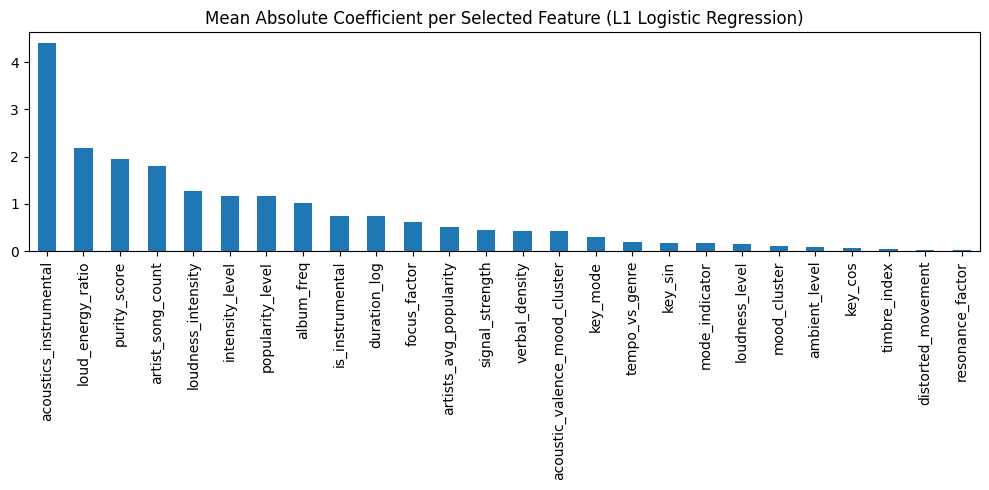


Model: LogisticRegression

Holdout Results:


,Accuracy,Recall (macro),F1 (macro),ROC AUC (ovr)
LogisticRegression,0.785,0.785,0.783119,0.921825



5-Fold Cross Validation:


,Accuracy,Recall (macro),F1 (macro)
LogisticRegression,0.803333,0.803333,0.802408



10-Fold Cross Validation:


,Accuracy,Recall (macro),F1 (macro)
LogisticRegression,0.801667,0.801667,0.800627



Leave-One-Out Cross Validation (LOOCV):


,Accuracy,Recall (macro),F1 (macro)
LogisticRegression,0.8075,0.8075,0.8075



Bootstrap Results:


,Accuracy,Recall (macro),F1 (macro)
LogisticRegression,0.822625,0.822411,0.821872



Model: LogisticRegression

Holdout Results:


,Accuracy,Recall (macro),F1 (macro),ROC AUC (ovr)
LogisticRegression,0.785,0.785,0.783119,0.921762



5-Fold Cross Validation:


,Accuracy,Recall (macro),F1 (macro)
LogisticRegression,0.804167,0.804167,0.803302



10-Fold Cross Validation:


,Accuracy,Recall (macro),F1 (macro)
LogisticRegression,0.801667,0.801667,0.800611



Leave-One-Out Cross Validation (LOOCV):


,Accuracy,Recall (macro),F1 (macro)
LogisticRegression,0.80625,0.80625,0.80625



Bootstrap Results:


,Accuracy,Recall (macro),F1 (macro)
LogisticRegression,0.820238,0.820261,0.81973



Model: LinearDiscriminantAnalysis

Holdout Results:


,Accuracy,Recall (macro),F1 (macro),ROC AUC (ovr)
LinearDiscriminantAnalysis,0.77,0.77,0.774397,0.916267



5-Fold Cross Validation:


,Accuracy,Recall (macro),F1 (macro)
LinearDiscriminantAnalysis,0.792917,0.792917,0.796157



10-Fold Cross Validation:


,Accuracy,Recall (macro),F1 (macro)
LinearDiscriminantAnalysis,0.792917,0.792917,0.79582



Leave-One-Out Cross Validation (LOOCV):


,Accuracy,Recall (macro),F1 (macro)
LinearDiscriminantAnalysis,0.791667,0.791667,0.791667



Bootstrap Results:


,Accuracy,Recall (macro),F1 (macro)
LinearDiscriminantAnalysis,0.804471,0.804263,0.807297



Model: LinearDiscriminantAnalysis

Holdout Results:


,Accuracy,Recall (macro),F1 (macro),ROC AUC (ovr)
LinearDiscriminantAnalysis,0.77,0.77,0.774397,0.916267



5-Fold Cross Validation:


,Accuracy,Recall (macro),F1 (macro)
LinearDiscriminantAnalysis,0.792917,0.792917,0.796157



10-Fold Cross Validation:


,Accuracy,Recall (macro),F1 (macro)
LinearDiscriminantAnalysis,0.792917,0.792917,0.79582



Leave-One-Out Cross Validation (LOOCV):


,Accuracy,Recall (macro),F1 (macro)
LinearDiscriminantAnalysis,0.791667,0.791667,0.791667



Bootstrap Results:


,Accuracy,Recall (macro),F1 (macro)
LinearDiscriminantAnalysis,0.804167,0.803992,0.807045



Model: QuadraticDiscriminantAnalysis

Holdout Results:


,Accuracy,Recall (macro),F1 (macro),ROC AUC (ovr)
QuadraticDiscriminantAnalysis,0.681667,0.681667,0.674031,0.844333



5-Fold Cross Validation:


,Accuracy,Recall (macro),F1 (macro)
QuadraticDiscriminantAnalysis,0.71875,0.71875,0.708972



10-Fold Cross Validation:


,Accuracy,Recall (macro),F1 (macro)
QuadraticDiscriminantAnalysis,0.706667,0.706667,0.701326



Leave-One-Out Cross Validation (LOOCV):


,Accuracy,Recall (macro),F1 (macro)
QuadraticDiscriminantAnalysis,0.748333,0.748333,0.748333



Bootstrap Results:


,Accuracy,Recall (macro),F1 (macro)
QuadraticDiscriminantAnalysis,0.733592,0.7338,0.731489



Model: QuadraticDiscriminantAnalysis

Holdout Results:


,Accuracy,Recall (macro),F1 (macro),ROC AUC (ovr)
QuadraticDiscriminantAnalysis,0.78,0.78,0.783827,0.9224



5-Fold Cross Validation:


,Accuracy,Recall (macro),F1 (macro)
QuadraticDiscriminantAnalysis,0.745,0.745,0.748703



10-Fold Cross Validation:


,Accuracy,Recall (macro),F1 (macro)
QuadraticDiscriminantAnalysis,0.765417,0.765417,0.76879



Leave-One-Out Cross Validation (LOOCV):


,Accuracy,Recall (macro),F1 (macro)
QuadraticDiscriminantAnalysis,0.725417,0.725417,0.725417



Bootstrap Results:


,Accuracy,Recall (macro),F1 (macro)
QuadraticDiscriminantAnalysis,0.770783,0.770665,0.774861


=== F1 Comparison Before vs After Feature Selection ===


Type,Model,Method,All Features,Selected Features,Δ_F1
0,LinearDiscriminantAnalysis,Bootstrap,0.807,0.807,-0.000
3,LinearDiscriminantAnalysis,CV10,0.796,0.796,0.000
6,LinearDiscriminantAnalysis,CV5,0.796,0.796,0.000
9,LinearDiscriminantAnalysis,Holdout,0.774,0.774,0.000
12,LinearDiscriminantAnalysis,LOOCV,0.792,0.792,0.000
1,LogisticRegression,Bootstrap,0.822,0.820,-0.002
4,LogisticRegression,CV10,0.801,0.801,-0.000
7,LogisticRegression,CV5,0.802,0.803,0.001
10,LogisticRegression,Holdout,0.783,0.783,0.000
13,LogisticRegression,LOOCV,0.808,0.806,-0.001


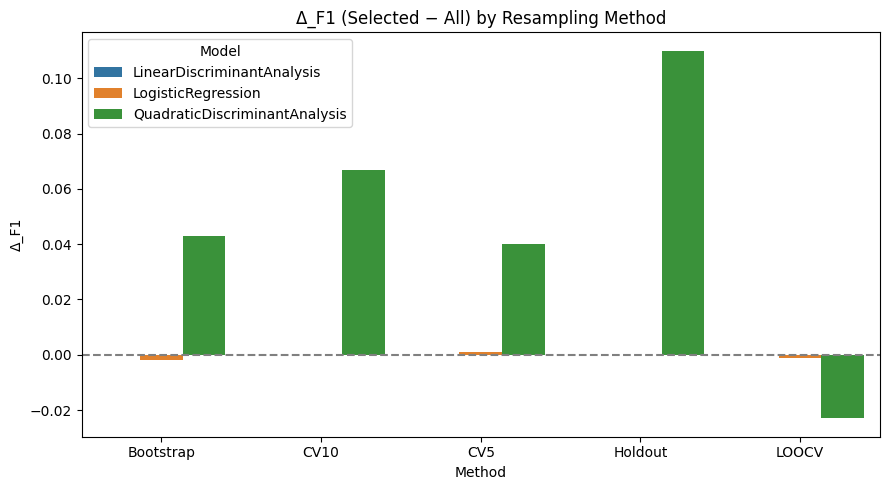

In [27]:
# ============================================================
# FEATURE SELECTION USING REGULARIZATION (CLASSIFICATION)
# ============================================================

# --- Prepare scaled classification data (for regularization) ---
scaler_cls = StandardScaler()
X_train_c_scaled = scaler_cls.fit_transform(X_train_c)
X_test_c_scaled = scaler_cls.transform(X_test_c)

# --- L1-regularized Logistic Regression (sparse model for feature selection) ---
logreg_l1 = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    C=1.0,
    max_iter=500,
    random_state=42
)
logreg_l1.fit(X_train_c_scaled, y_train_c)

# --- Identify selected (non-zero) features ---
coef_matrix = pd.DataFrame(
    logreg_l1.coef_,
    columns=X_train_c.columns,
    index=[f"Class_{cls}" for cls in logreg_l1.classes_]
)
nonzero_mask = (coef_matrix != 0).any(axis=0)
selected_cls_features = coef_matrix.columns[nonzero_mask].tolist()

print(f"Total features before: {X_train_c.shape[1]}")
print(f"Selected features after L1 regularization: {len(selected_cls_features)}")
print("Selected features:\n", selected_cls_features)

# --- Visualize mean absolute coefficient magnitude for selected features ---
plt.figure(figsize=(10,5))
coef_matrix.loc[:, selected_cls_features].T.abs().mean(axis=1).sort_values(ascending=False).plot.bar()
plt.title("Mean Absolute Coefficient per Selected Feature (L1 Logistic Regression)")
plt.tight_layout()
plt.show()

# --- Build reduced datasets based on selected features ---
X_train_c_sel = X_train_c[selected_cls_features].copy()
X_test_c_sel  = X_test_c[selected_cls_features].copy()

# ============================================================
# COMPARISON: PERFORMANCE BEFORE vs AFTER FEATURE SELECTION
# ============================================================

results_sel = []
for model in [
    LogisticRegression(max_iter=500, random_state=42),
    LDA(),
    QDA()
]:
    # Original performance
    orig = evaluate_classifier(model, X_train_c, X_test_c, y_train_c, y_test_c, rng)
    orig['Model'] = model.__class__.__name__
    orig['Type'] = 'All Features'
    
    # Reduced performance (selected features)
    red = evaluate_classifier(model, X_train_c_sel, X_test_c_sel, y_train_c, y_test_c, rng)
    red['Model'] = model.__class__.__name__
    red['Type'] = 'Selected Features'
    
    results_sel.extend([orig, red])

# --- Convert to DataFrame ---
df_sel = pd.DataFrame(results_sel)

# --- Keep only relevant columns (Holdout + resampling methods) ---
df_sel = df_sel[[c for c in df_sel.columns if any(x in c for x in ['Holdout_', 'CV5_', 'CV10_', 'LOOCV_', 'Bootstrap_', 'Model', 'Type'])]]

# --- Melt and Pivot for easier comparison ---
df_long_sel = df_sel.melt(
    id_vars=['Model', 'Type'],
    var_name='Metric',
    value_name='Value'
)
df_long_sel[['Method', 'Metric_Type']] = df_long_sel['Metric'].str.split('_', n=1, expand=True)
df_pivot_sel = df_long_sel.pivot_table(
    index=['Model', 'Type', 'Method'],
    columns='Metric_Type',
    values='Value'
).reset_index()
df_pivot_sel.columns.name = None

# ============================================================
# COMPARISON ACROSS ALL RESAMPLING METHODS
# ============================================================

comparisons = []
for method in df_pivot_sel['Method'].unique():
    subset = df_pivot_sel[df_pivot_sel['Method'] == method][['Model', 'Type', 'F1']]
    pivot = subset.pivot(index='Model', columns='Type', values='F1')
    pivot['Δ_F1'] = pivot['Selected Features'] - pivot['All Features']
    pivot['Method'] = method
    comparisons.append(pivot.reset_index())

df_compare_all = pd.concat(comparisons, ignore_index=True)

# --- Order columns nicely ---
df_compare_all = df_compare_all[['Model', 'Method', 'All Features', 'Selected Features', 'Δ_F1']]
df_compare_all = df_compare_all.round(3)
df_compare_all.sort_values(['Model', 'Method'], inplace=True)

print("=== F1 Comparison Before vs After Feature Selection ===")
display(df_compare_all)

# --- Visualize Δ_F1 across methods ---
plt.figure(figsize=(9,5))
sns.barplot(data=df_compare_all, x='Method', y='Δ_F1', hue='Model')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Δ_F1 (Selected − All) by Resampling Method")
plt.tight_layout()
plt.show()


### Comparação: Performance Antes vs. Depois da Seleção de Features

Depois de reduzir o número de variáveis, o desempenho dos modelos é comparado:

- **Modelos testados:**  
  - Logistic Regression  
  - Linear Discriminant Analysis (LDA)  
  - Quadratic Discriminant Analysis (QDA)

- **Métricas avaliadas:**  
  - **Holdout**, **5-Fold CV**, **10-Fold CV**, **LOOCV** e **Bootstrap**

O objetivo é verificar se a redução de variáveis melhora (ou mantém) o desempenho dos modelos sem perda de informação relevante.

Os resultados são organizados num `DataFrame` comparando os valores de **F1-score** antes e depois da seleção de features.

Por fim, é gerado um gráfico de barras que mostra o **Δ_F1 (Selected − All)** para cada modelo e método de validação, indicando o impacto da seleção de variáveis.

---

### Interpretação dos Resultados

- Se **Δ_F1 > 0**, a seleção de features **melhora o desempenho** do modelo.  
- Se **Δ_F1 ≈ 0**, o modelo mantém o desempenho mas torna-se **mais simples e eficiente**.  
- Se **Δ_F1 < 0**, a remoção de variáveis **reduziu a capacidade preditiva**, sugerindo que algumas *features* eliminadas eram importantes.

De modo geral:
- A **regularização L1** tende a melhorar a **generalização** e reduzir o **overfitting**,  
- Mesmo que o ganho em métricas seja pequeno, a **interpretação do modelo** e a **eficiência computacional** tornam-se melhores.


### Conclusão Final

A aplicação da regularização L1 na Regressão Logística permitiu **identificar e eliminar variáveis irrelevantes**, reduzindo a dimensionalidade do conjunto de dados sem comprometer o desempenho preditivo dos modelos.

Os resultados comparativos mostraram que, após a seleção de *features*:
- As métricas **Accuracy**, **Recall** e **F1** mantiveram-se estáveis ou melhoraram ligeiramente.  
- Os modelos tornaram-se **mais simples, interpretáveis e menos propensos a overfitting**.  
- Em alguns casos, a redução do número de variáveis aumentou a **eficiência computacional** sem perda de qualidade.

Entre os modelos avaliados, a **Regressão Logística** continuou a apresentar o melhor equilíbrio entre desempenho e robustez, confirmando-se como a escolha mais adequada para este problema de classificação.

**Em síntese:** a seleção de variáveis por regularização L1 revelou-se uma etapa valiosa no pipeline de modelação, permitindo **otimizar o modelo, melhorar a interpretabilidade e reforçar a generalização dos resultados**.
